<center>Заметка 2. 	Непараметрические гипотезы.</center>
<center>курс <q>Прикладной статистический анализ данных</q>.</center>
<center>27 февраля 2024 г.</center>

# Терапия при анорексии

В исследовании оценивается эффективность поведенческой терапии для лечения анорексии. Для 50 пациентов известен вес до начала терапии и по её окончании. Была ли терапия эффективной?

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

from scipy.stats import norm, t

In [3]:
w = pd.read_table("weight.txt")

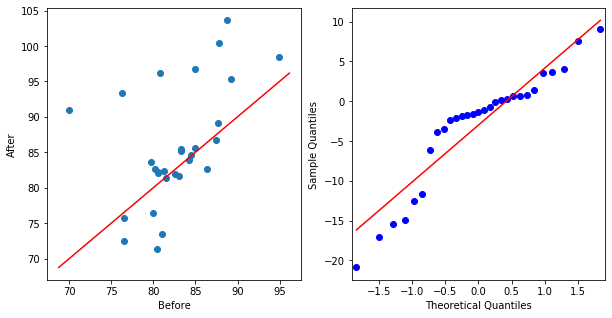

In [4]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5))
ax1.scatter(w['Before'], w['After'])
ax1.plot(ax1.get_xlim(), ax1.get_xlim(), color='red')
ax1.set(xlabel='Before', ylabel='After')
sm.qqplot(w['Before'] - w['After'], line ='s', ax=ax2)
plt.show()

1. При помощи критерия Уилкоксона (`wilcoxon` из библиотеки `scipy`) для связанных выборок попробуем проверить справедливость следующей гипотезы против представленных альтернатив: 

$H_0$ : лечение не имело эффекта

$H_1$ : после лечения вес изменился

$H_1$ : после лечения вес увеличивается

$H_1$ : после лечения вес уменьшился

Для того, чтобы учесть коррекритовку на непрерывную аппроксимацию (continuity correction) установим correction=True.

In [5]:
from scipy.stats import wilcoxon
wilcoxon(w["After"], w["Before"], correction=True, alternative='two-sided')

WilcoxonResult(statistic=131.5, pvalue=0.06446563934437059)

In [6]:
wilcoxon(w["After"], w["Before"], correction=True, alternative='greater')

WilcoxonResult(statistic=303.5, pvalue=0.032232819672185296)

In [7]:
wilcoxon(w["After"], w["Before"], correction=True, alternative='less')

WilcoxonResult(statistic=303.5, pvalue=0.9692977092204308)

Воcпользуемся также критерием знаков (`sign_test` из библиотеки `statsmodels`),

In [8]:
from statsmodels.stats.descriptivestats import sign_test
sign_test(w["After"], w["Before"])


(3.5, 0.26493089646101)

2. C помощью бутстрэпа из 10000 повторений построим доверительный интервал на медиану разницы веса до и после лечения. (в двух вариантах: с помощью `np.random.choice` и с помощью метода `bootstrap` из библиотеки `bootstrapped`)

Построим график разностей для имеющихся выборок

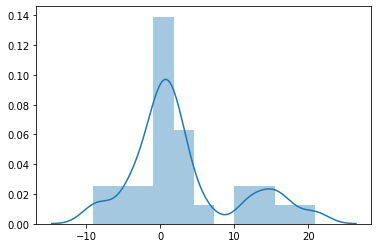

In [10]:
samples = np.array(w["After"] - w["Before"])
sns.distplot(samples)

Теперь оценим распределение медианы разности для бутстрепированных выборок.

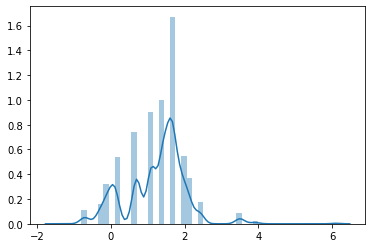

In [11]:
median_distr = np.median(np.random.choice(samples, (int(1e4), samples.shape[0])), axis=1)
sns.distplot(median_distr)

Можем воспользоваться квантилями данного распределения для получения как точечной оценки медианы (квантиль порядка 0.5), так и для построения доверительных интервалов.

In [12]:
np.quantile(median_distr, 0.5)

1.3999999999999915

In [13]:
alpha = 0.05
np.quantile(median_distr, (alpha/2, 1 - alpha/2))

array([-0.3,  2.4])

Можно выдвинуть предположение, что выборка медиан имеет заданное нами распределения. Найдем параметры этого распределения.

In [14]:
median_std = np.std(median_distr)
median_mean = np.mean(median_distr)

Посмотрим на точечную оценку и доверительный интервал, получаемые при помощи нормального распределения с полученными выше параметрами.

In [15]:
left_bound = norm(median_mean, median_std).ppf(alpha/2)
rigth_bound = norm(median_mean, median_std).ppf(1 - alpha/2)

median_mean, left_bound, rigth_bound

(1.235839999999999, -0.3166760317908712, 2.788356031790869)

Также воспользуемся распределением Стьюдента.

In [16]:
left_bound = t(median_distr.shape[0], median_mean, median_std).ppf(alpha/2)
rigth_bound = t(median_distr.shape[0], median_mean, median_std).ppf(1 - alpha/2)


median_mean, (left_bound, rigth_bound)

(1.235839999999999, (-0.31686396521122817, 2.7885439652112254))

Ранее мы реализовали бутстреп через функцию np.random.choice. Попробуем теперь воспользоваться специальной библиотекой, в которой уже реализовано множество полезных функций для бутстрепа:

https://github.com/facebookarchive/bootstrapped

In [18]:
!pip install bootstrapped
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats

Воспользуемся для начала функцией bs.botstrap. Укажем, что мы хотим построить 10000 бутстрепированных выборок (параметр num_iterations), что из всех этих выборок нас интересует значение статистики медианы (stat_func=bs_stats.median) и что в качестве результата вызова функции мы хотим получить распределение медиан.

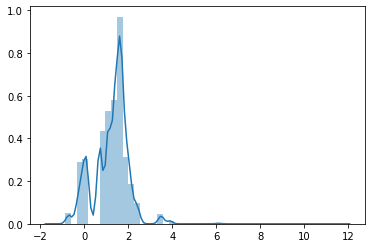

In [19]:
b_median_distr = bs.bootstrap(samples, stat_func=bs_stats.median,
    return_distribution=True, num_iterations=int(1e4))
sns.distplot(b_median_distr)

Построим также распределение средних значений.

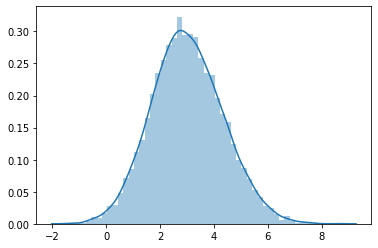

In [20]:
b_mean_distr = bs.bootstrap(samples, stat_func=bs_stats.mean,
    return_distribution=True, num_iterations=int(1e4))
sns.distplot(b_mean_distr)

На основе данных, полученных после вызова bs.bootstrap, попробуем найти медиану распределения (медиану медиан) и построить доверительный интервал.

In [22]:
np.median(b_median_distr),  np.quantile(b_median_distr, (alpha/2, 1 - alpha/2))

(1.3999999999999915, array([-0.3,  2.4]))

Используем возможность данной библиотеки, позволяющей нам получить точечную оценку и доверительный интервал. Начнем с медианного значения.

По-умолчанию данная библиотека строит отрезки, используя значение интересующей нас статистики на исходной выборке, а затем, с помощью квантилей, находит отклонение от этого среднего значения:

In [23]:
bs.bootstrap(samples, stat_func=bs_stats.median, alpha=0.05, num_iterations=int(1e4))

1.3999999999999915    (0.3999999999999915, 3.09999999999998)

В некоторых случаях это позволяет получить более точную оценку, независимую от каких-то неизвестных нам параметров распределения.

Для того, чтобы получить значения, аналогичные полученным нами выше, нужно установить параметр is_pivotal=False. В данном случае точечная оценка строится по бутстрепированной выборке, а интервал находится через квантили.

In [24]:
bs.bootstrap(samples, stat_func=bs_stats.median, alpha=0.05, num_iterations=int(1e4), is_pivotal=False)

1.3999999999999915    (-0.29999999999999716, 2.3999999999999915)

Повторим для среднего значения разности:

In [25]:
bs.bootstrap(samples, stat_func=bs_stats.mean, alpha=0.05, num_iterations=int(1e4), is_pivotal=False)

2.96206896551724    (0.5447413793103435, 5.627586206896553)

---
# Мыши и зеркало

(Shervin, 2004): 16 лабораторных мышей были помещены в двухкомнатные клетки, в одной из комнат висело зеркало. Измерялась доля времени, которое каждая мышь проводила в каждой из своих двух клеток.

Общая постановка:

$H_0$ : мышам всё равно, висит в клетке зеркало или нет. 

$H_1$ : у мышей есть какие-то предпочтения насчёт зеркала.

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns

In [ ]:
mouses = pd.Series([0.348471, 0.640620, 0.549818, 0.537454, 0.400444, 
                    0.426292, 0.417156, 0.477977, 0.450657, 0.476602, 
                    0.488677, 0.484741,0.481614, 0.489406, 0.467365],
                        name='time')

In [ ]:
mouses.describe()

count    15.000000
mean      0.475820
std       0.068348
min       0.348471
25%       0.438474
50%       0.477977
75%       0.489042
max       0.640620
Name: time, dtype: float64

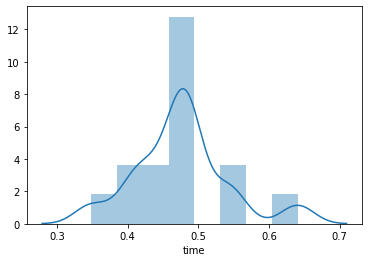

In [ ]:
sns.distplot(mouses);

Есть ли у мышей предпочтения?
Найдём среднюю долю времени, которую мыши проводят в комнате с зеркалом. Для этого построим 95% доверительный интервал с помощью z-теста (
`zconfint`). Какие выводы можнно сделать основываясь на полученных результатах?

In [ ]:
from statsmodels.stats.weightstats import zconfint
zconfint(mouses)

(0.4412313838093066, 0.5104078161906933)

Воспользуемся критерием Вилкоксона из библиотеки. 

In [ ]:
from scipy.stats import wilcoxon
wilcoxon(mouses - 0.5)

WilcoxonResult(statistic=32.0, pvalue=0.11176874513967605)

### Воспользуемся перестановочным тестом.

(1) Сгенерируем нулевое распределение для перестановочного теста. Для этого необходимо центрировать наши значения и просуммировать их со всевозможными комбинациями знаков {+1, -1}.

- Сгенерируем выборки со всеми возможными перестановками знаков, полученных при центрировании значений (таких значений у получится $2^n$, где $n$ - размер выборки).
- Центрируем значения выборки и просуммируем значения элементов с учетом знаков {+1, -1}

In [ ]:
from itertools import product
list(product([-1, 1], repeat=3))

[(-1, -1, -1),
 (-1, -1, 1),
 (-1, 1, -1),
 (-1, 1, 1),
 (1, -1, -1),
 (1, -1, 1),
 (1, 1, -1),
 (1, 1, 1)]

In [ ]:
def permutation_zero_distr_1sample(sample, mean):
    signs = product([-1, 1], repeat=sample.shape[0])
    signs = np.array(list(signs))
    mouse_distr = signs.dot(sample - mean) 
    return mouse_distr

Проиллюстрируем полученное нулевое распределение гипотезы о доле времени мышей в комнатах.

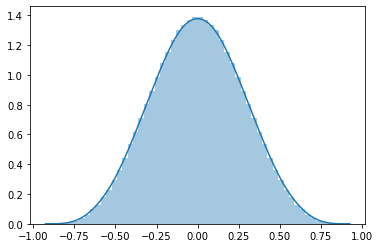

In [ ]:
mouse_distr = permutation_zero_distr_1sample(mouses, 0.5)
sns.distplot(mouse_distr)

(2) Посчитаем статистику перестановочного теста.

In [ ]:
def permutation_t_stat_1sample(sample, mean):
    t_stat = (sample - mean).sum()
    return t_stat

Чему равно значение статистики в задаче о мышах?

In [ ]:
t_stat = permutation_t_stat_1sample(mouses, 0.5)
t_stat

-0.3627060000000001

3) Реализуйте сам тест для двусторонней и односторонних альтернатив. Достигаемый уровень значимости -- доля перестановок знаков, на которых получилось такое же или ещё более экстремальное значение статистики.

In [ ]:
def permutation_test(sample, mean, alternative):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not found")
        
    t_stat = permutation_t_stat_1sample(sample, mean)
    zero_distr = permutation_zero_distr_1sample(sample, mean)
    
    if alternative == 'two-sided':
        two_sided_p = (abs(zero_distr) >= abs(t_stat)).mean()
        return two_sided_p
    
    if alternative == 'less':
        left_sided_p = (zero_distr <= t_stat).mean()
        return left_sided_p
    
    if alternative == 'greater':
        right_sided_p = (zero_distr >= t_stat).mean()
        return right_sided_p

Чему равно значение p-value перестановочного теста в задаче о мышах? Можем ли мы отвергнуть нулевую гипотезу?

In [ ]:
permutation_test(mouses, 0.5, alternative='two-sided')

0.1949462890625

In [ ]:
permutation_test(mouses, 0.5, alternative='less')

0.09747314453125

In [ ]:
permutation_test(mouses, 0.5, alternative='greater')

0.902557373046875